In [29]:
# If the models/indices do not exist on disk already, set this to True to generate them.
# Otherwise, load from disk and save lots of time.
train = False

In [2]:
import csv
import matplotlib.pyplot as plt
import pathlib
import random
import time

from gensim.parsing.preprocessing import preprocess_string
from gensim.corpora.textcorpus import TextCorpus
from gensim.models import LsiModel, LdaModel
from gensim import similarities
from gensim import utils
from numpy import dot
from scipy import sparse
from sklearn.manifold import TSNE

In [34]:
# TODO: add processing sections to get different fields from the iteration.
# Subclass from TextCorpus - convenient way to iterate through corpus in a memory efficient way.
class CSVCorpus(TextCorpus):
    def getstream(self):
        with open(pathlib.Path(self.input)) as csv_file:
            reader = csv.DictReader(csv_file)
            for row in reader:
                yield row["text"]
    def get_docs(self):
        for doc in self.getstream():
            tokens = preprocess_string(utils.to_unicode(doc))
            yield tokens
        return
    def get_doc(self, doc_index):
        for idx, doc in enumerate(self.getstream()):
            if idx == doc_index:
                tokens = preprocess_string(utils.to_unicode(doc))
                return tokens
    def __len__(self):
        self.length = sum(1 for _ in self.get_texts())
        return self.length

In [15]:
# Functions...
def get_similarity_matrix(model, model_name, train):
    if train:
        t0 = time.time()
        index = similarities.MatrixSimilarity(model[cc])
        t1 = time.time()
        index.save(f"data/lyrics_{model_name}.index")
        print(f"Constructed {model_name} Similarity Matrix in {(t1-t0)/60} minutes")
        print(f"Persisted {model_name} index to disk.")
    else:
        index = similarities.MatrixSimilarity.load(f"data/lyrics_{model_name}.index")
        print(f"Loaded {model_name} index from Disk.")
    return index

def flatten(lst):
    """Helper function to make sparse COO matrix.
    """
    flat_list = [item for sublist in lst for item in sublist]
    return flat_list

In [5]:
datapath = pathlib.Path("data/songdata.csv")

In [35]:
# Instantiate corpus
t0 = time.time()
cc = CSVCorpus(datapath)
t1 = time.time()
print(f"Set Custom CSV Corpus in {(t1-t0)/60} minutes.")
print("Number of documents: {}".format(len(cc)))
print("Number of unique items in dictionary: {}".format(len(cc.dictionary)))

Set Custom CSV Corpus in 0.41842538913091026 minutes.


In [8]:
# Train or Load LSI  model.
if train:
    t0 = time.time()
    lsi = LsiModel(cc, id2word=cc.dictionary, num_topics=150, onepass=False)
    t1 = time.time()
    lsi.save("data/lsi.model")
    print("Trained LSI model in: {} minutes".format((t1-t0)/60.0))
    print("Persisted  LSI model to disk.")
else:
    lsi = LsiModel.load("data/lsi.model")
    print("Loaded LSI model from disk.")

Trained LSI model in: 2.180571969350179 minutes
Persisted  LSI model to disk.


In [9]:
# Train or Load LDA model.
if train:
    t0 = time.time()
    lda = LdaModel(cc, id2word=cc.dictionary, num_topics=150, passes=5)
    t1 = time.time()
    lda.save("data/lda.model")
    print("Trained LDA model in: {} minutes".format((t1-t0)/60.0))
    print("Persisted LDA model to disk.")
else:
    lda = LdaModel.load("data/lda.model")
    print("Loaded LDA model from disk.")

Trained LDA model in: 11.256805618604025 minutes
Persisted LDA model to disk.


In [16]:
# Train or load similarity matrix
lda_index = get_similarity_matrix(lda, "lda", train)
lsi_index = get_similarity_matrix(lsi, "lsi", train)

Constructed lda Similarity Matrix in 4.5720011472702025 minutes
Persisted lda index to disk.
Constructed lsi Similarity Matrix in 1.3128353079160056 minutes
Persisted lsi index to disk.


In [ ]:
first_song = cc.get_doc(0)
sims = lsi_index[lsi[cc.dictionary.doc2bow(first_song)]]
ordered_sims = sorted(enumerate(sims), key = lambda k: k[1], reverse=True)

In [64]:
# See top 10 most similar songs... (by id and similarity score.)
print("song_id:\tsimilarity_score")
print("--------------------------")
for song_id, similarity_score in ordered_sims[:10]:
    print(f"{song_id}:\t\t{similarity_score}")

song_id:	similarity_score
--------------------------
0:		0.8806207776069641
27565:		0.7375124096870422
6057:		0.7239879369735718
19592:		0.7179632186889648
15748:		0.7116075754165649
7461:		0.6979591250419617
37217:		0.6752104163169861
52857:		0.6650410294532776
31573:		0.6641811728477478
33043:		0.6357895731925964


In [38]:
# print some song lyrics...
x = cc.get_doc(0)
y = cc.get_doc(27565)
print(x)
print("-------")
print(y)

['look', 'face', 'wonder', 'face', 'mean', 'special', 'look', 'wai', 'smile', 'see', 'lucki', 'fellow', 'kind', 'girl', 'make', 'feel', 'fine', 'believ', 'kind', 'girl', 'blue', 'leav', 'walk', 'park', 'hold', 'squeez', 'hand', 'walk', 'hour', 'talk', 'thing', 'plan', 'kind', 'girl', 'make', 'feel', 'fine', 'believ', 'kind', 'girl', 'blue', 'leav']
-------
['catfish', 'girl', 'make', 'feel', 'fine', 'catfish', 'girl', 'pull', 'line', 'smile', 'face', 'singl', 'time', 'yeah', 'catfish', 'girl', 'miss', 'lord', 'feel', 'blue', 'catfish', 'girl', 'littl', 'thing', 'catfish', 'girl', 'want', 'catfish', 'come', 'ain', 'prettiest', 'thing']


In [42]:
# Build matrix of songs and their values for topics.
# TODO: Need to adapt this to work with LDA. Currently, only LSI is supported.
vecs = []
for song_idx, song in enumerate(cc.get_docs()):
    vecs.append(lsi[cc.dictionary.doc2bow(song)])
X = sparse.coo_matrix(
    ([t[1] for vec in vecs for t in vec],
    (flatten([[i]*len(vec) for i, vec in enumerate(vecs)]), [t[0] for vec in vecs for t in vec])))

In [ ]:
# TODO: get some labels for the songs. perhaps artist, or maybe extract some "genre"?

In [48]:
# Now lets do some neat dimensionality reduction and get a visualization of our clusters.
X_embedded = TSNE(n_components=2).fit_transform(X.toarray())
X_sampled = random.sample(set((x,y) for x,y in X_embedded), 2000)

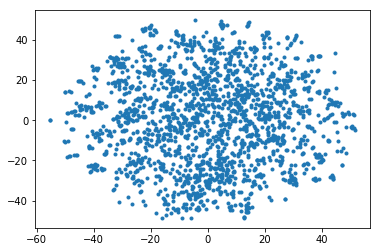

In [59]:
xx = [e[0] for e in X_sampled]
yy = [e[1] for e in X_sampled]
plt.plot(xx, yy, '.')
plt.show()